In [6]:
import os
import json
import pandas as pd

# Path to the folder containing the processed data
PROCESSED_DIR = "/home/simcard/city_data_parquet/processed_data_parquet"

# Dictionaries for storing data
processed_frames = {}
processed_logs = {}

# List all files in the folder
all_files = os.listdir(PROCESSED_DIR)
# Filter by JSON files, as these are the “table of contents” for the Parquets.
json_files = sorted([f for f in all_files if f.endswith('.json')])

print(f"Load Data: {PROCESSED_DIR}")
print(f"Found {len(json_files)} city data pairs.\n")

for j_file in json_files:
    # Build paths
    j_path = os.path.join(PROCESSED_DIR, j_file)
    p_path = j_path.replace('.json', '.parquet')
    
    # Load log file (JSON)
    with open(j_path, 'r') as f:
        meta = json.load(f)
    
    city_name = meta['city']
    processed_logs[city_name] = meta
    
    # Loading Parquet file
    if os.path.exists(p_path):
        df = pd.read_parquet(p_path)
        processed_frames[city_name] = df
        
        # Brief status report
        start = meta['time_frame']['start_exact'][:10] # Nur Datum
        end = meta['time_frame']['end_exact'][:10]
        vars_count = meta['variables']['count']
        
        print(f"✅ {city_name:<18} | {len(df):>7} rows | {vars_count} Vars | {start} bis {end}")
    else:
        print(f"⚠️ Warning: Parquet file for {city_name} is missing!")

print(f"\n All data successfully loaded into ‘processed_frames’ and ‘processed_logs’.")

Load Data: /home/simcard/city_data_parquet/processed_data_parquet
Found 5 city data pairs.

✅ bordeaux           |  315576 rows | 14 Vars | 1990-01-01 bis 2025-12-31
✅ lyon               |  315576 rows | 14 Vars | 1990-01-01 bis 2025-12-31
✅ marseille          |  315576 rows | 14 Vars | 1990-01-01 bis 2025-12-31
✅ marseillemarignane |  315576 rows | 14 Vars | 1990-01-01 bis 2025-12-31
✅ paris              |  315576 rows | 14 Vars | 1990-01-01 bis 2025-12-31

 All data successfully loaded into ‘processed_frames’ and ‘processed_logs’.


In [9]:
# Optional: Reduce memory consumption by approx. 50%
for city in processed_frames:
    # Convert float64 to float32
    cols = processed_frames[city].select_dtypes(include=['float64']).columns
    processed_frames[city][cols] = processed_frames[city][cols].astype('float32')

In [10]:
example_city = list(processed_frames.keys())[0]
df = processed_frames[example_city]

print("=== INDEX ===")
print(type(df.index))
print(df.index[:5])

print("\n=== COLUMNS ===")
print(df.columns.tolist())

print("\n=== HEAD ===")
print(df.head(3))

print("\n=== DTYPES ===")
print(df.dtypes)

=== INDEX ===
<class 'pandas.core.indexes.range.RangeIndex'>
RangeIndex(start=0, stop=5, step=1)

=== COLUMNS ===
['timestamp', 'temperature_2m', 'relative_humidity_2m', 'pressure_msl', 'shortwave_radiation', 'soil_moisture_0_to_7cm', 'wind_speed_10m', 't_850hPa', 't_500hPa', 'u_850hPa', 'u_500hPa', 'v_850hPa', 'v_500hPa', 'wind_dir_sin', 'wind_dir_cos']

=== HEAD ===
            timestamp  temperature_2m  relative_humidity_2m  pressure_msl  \
0 1990-01-01 00:00:00          4.5865             96.222481   1017.500000   
1 1990-01-01 01:00:00          4.2865             96.892365   1017.000000   
2 1990-01-01 02:00:00          4.1865             97.231163   1016.700012   

   shortwave_radiation  soil_moisture_0_to_7cm  wind_speed_10m    t_850hPa  \
0                  0.0                   0.287        7.172949  277.720581   
1                  0.0                   0.287        6.214563  277.574951   
2                  0.0                   0.287        5.804825  277.428101   

     t_

In [ ]:
# -----------------------------------------------------------------------
# FEATURE ENGINEERING — EXPLANATION
# -----------------------------------------------------------------------
#
# 1. Z-SCORE NORMALIZATION (leakage-free)
#    Removes the diurnal cycle and seasonal variation from each variable.
#    For each variable, mean and standard deviation are computed per
#    day-of-year × hour, using only the training period (1990–2015).
#    Result: a value of +2.0 means "2 standard deviations above what is
#    normal for this hour on this day of the year" — independent of
#    season or time of day. Prevents the model from learning trivial
#    patterns like "July is warmer than January".
#
# 2. CYCLICAL TIME ENCODING
#    hour_sin / hour_cos:  encodes the hour of day as a point on a circle,
#                          so that 23:00 and 00:00 are treated as adjacent.
#    doy_sin  / doy_cos:   same principle for day of year, so that
#                          December 31 and January 1 are adjacent.
#    Without cyclical encoding, a linear model would treat midnight and
#    noon as maximally different, which is physically wrong. --> maybe not absolutely necessary
#
# 3. LAG FEATURES
#    lag_t850_72h:   temperature at 850 hPa 72 hours ago.
#                    Large-scale warm air advection builds up over days —
#                    the atmospheric state 3 days ago is a strong predictor
#                    of today's heatwave risk.
#    lag_press_48h:  mean sea level pressure 48 hours ago.
#                    Anticyclonic build-up (rising pressure) typically
#                    precedes heatwaves by 1–2 days.
#    lag_v850_72h:   meridional (north-south) wind at 850 hPa 72h ago.
#                    Southerly flow transports warm air from North Africa —
#                    a key precursor to Western European heatwaves.
#    lag_t500_72h:   temperature at 500 hPa (~5500m) 72 hours ago.
#    lag_t500_48h:   temperature at 500 hPa 48 hours ago.
#                    Upper-level warmth is critical for atmospheric
#                    blocking — without a warm upper atmosphere, surface
#                    heat dissipates quickly and no sustained heatwave forms.
#
# 4. TENDENCY FEATURES
#    delta_press_24h:  pressure change over the last 24 hours.
#                      Rising pressure indicates an approaching anticyclone
#                      (high pressure system) — the synoptic pattern most
#                      associated with European heatwaves.
#                      Falling pressure indicates incoming disturbances
#                      that typically break heatwave conditions.
#    delta_hum_24h:    humidity change over the last 24 hours.
#                      A rapid drying trend signals reduced cloud cover
#                      and increased surface heating — a heatwave amplifier.
#
# 5. HEAT ARIDITY INDEX
#    heat_aridity_index = (t_850hPa in °C) - relative_humidity_2m
#    Combines upper-level warmth with surface dryness in a single value.
#    High values (hot + dry) indicate strong heatwave potential.
#    Low values (cool + humid) suppress heatwave development.
#    t_850hPa is converted from Kelvin to Celsius before subtraction
#    so that the index is physically interpretable on a consistent scale.
#    Example:
#      t_850hPa = 22°C, humidity = 20% → index = +2  (high risk)
#      t_850hPa = 15°C, humidity = 70% → index = -55 (low risk)
#
# 6. SMOOTHED MERIDIONAL WIND (V850)
#    v850_smooth_6h: 6-hour rolling mean of v_850hPa.
#    Reduces hour-to-hour noise in the wind signal.
#    Persistent southerly flow (positive v_850hPa) over several hours
#    is a much stronger heatwave signal than a single-hour spike.
# -----------------------------------------------------------------------

In [11]:
################################################################################
# FEATURE ENGINEERING - TARGETED
# Based on 7 features + Z-score + city + time
# heat_aridity_index corrected in Celsius
################################################################################
import numpy as np
import pandas as pd
from concurrent.futures import ThreadPoolExecutor

TRAIN_END = '2015-12-31'
REF_START = '1990-01-01'

ZSCORE_COLS = [
    'temperature_2m', 't_850hPa', 't_500hPa',
    'pressure_msl', 'relative_humidity_2m',
    'soil_moisture_0_to_7cm', 'wind_speed_10m',
    # 'shortwave_radiation' ← removed due to outlier problem (nighttime = 0)
]

def compute_climatology(df: pd.DataFrame, cols: list) -> dict:
    ref = df[REF_START:TRAIN_END]
    clim = {}
    for col in cols:
        if col not in df.columns:
            continue
        grp = ref.groupby([ref.index.dayofyear, ref.index.hour])[col]
        clim[col] = {'mean': grp.mean(), 'std': grp.std()}
    return clim

def apply_zscore(df: pd.DataFrame, clim: dict) -> pd.DataFrame:
    doy  = df.index.dayofyear.values
    hour = df.index.hour.values
    for col, stats in clim.items():
        if col not in df.columns:
            continue
        mean_2d = stats['mean'].unstack(level=1).values
        std_2d  = stats['std'].unstack(level=1).values
        mean_arr = mean_2d[doy - 1, hour]
        std_arr  = std_2d[doy - 1, hour]
        df[f'{col}_zscore'] = (df[col].values - mean_arr) / (std_arr + 1e-8)
    return df

def engineer_features(df: pd.DataFrame, city_name: str) -> tuple:
    df = df.copy()
    
    if 'timestamp' in df.columns:
        df = df.set_index('timestamp')
        df.index = pd.to_datetime(df.index)

    # ------------------------------------------------------------------ #
    # 1. Z-SCORE (leakage-free, only from training period)
    # ------------------------------------------------------------------ #
    clim = compute_climatology(df, ZSCORE_COLS)
    df = apply_zscore(df, clim)

    # ------------------------------------------------------------------ #
    # 2. Temporal context features (cyclical)
    # ------------------------------------------------------------------ #
    df['hour_sin'] = np.sin(2 * np.pi * df.index.hour / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df.index.hour / 24)
    df['doy_sin']  = np.sin(2 * np.pi * df.index.dayofyear / 365)
    df['doy_cos']  = np.cos(2 * np.pi * df.index.dayofyear / 365)

    # ------------------------------------------------------------------ #
    # 3. LAG FEATURES
    # ------------------------------------------------------------------ #
    if 't_850hPa' in df.columns:
        df['lag_t850_72h']  = df['t_850hPa'].shift(72)
    if 'pressure_msl' in df.columns:
        df['lag_press_48h'] = df['pressure_msl'].shift(48)
    if 'v_850hPa' in df.columns:
        df['lag_v850_72h']  = df['v_850hPa'].shift(72)

    if 't_500hPa' in df.columns:                           # NEU
        df['lag_t500_72h']  = df['t_500hPa'].shift(72)     # NEU
        df['lag_t500_48h']  = df['t_500hPa'].shift(48)     # NEU

    # ------------------------------------------------------------------ #
    # 4. TENDENCY FEATURES
    # ------------------------------------------------------------------ #
    if 'pressure_msl' in df.columns:
        df['delta_press_24h'] = df['pressure_msl'] - df['pressure_msl'].shift(24)
    if 'relative_humidity_2m' in df.columns:
        df['delta_hum_24h']   = df['relative_humidity_2m'] - df['relative_humidity_2m'].shift(24)

    # ------------------------------------------------------------------ #
    # 5. HEAT ARIDITY INDEX (t_850hPa in Celsius)
    # ------------------------------------------------------------------ #
    if 't_850hPa' in df.columns and 'relative_humidity_2m' in df.columns:
        t850_celsius = df['t_850hPa'] - 273.15
        df['heat_aridity_index'] = t850_celsius - df['relative_humidity_2m']

    # ------------------------------------------------------------------ #
    # 6. V850 SMOOTHED
    # ------------------------------------------------------------------ #
    if 'v_850hPa' in df.columns:
        df['v850_smooth_6h'] = df['v_850hPa'].rolling(window=6).mean()

    print(f"  ✅ {city_name}: Features engineered. Shape: {df.shape}")
    return df, clim

################################################################################
# APPLY TO ALL CITIES (parallelized)
################################################################################

def process_city(args):
    city, df = args
    return city, engineer_features(df, city)

engineered_frames = {}
city_climatologies = {}

print("Starting Feature Engineering...\n")
with ThreadPoolExecutor(max_workers=5) as executor:
    results = list(executor.map(process_city, processed_frames.items()))

for city, (df, clim) in results:
    engineered_frames[city] = df
    city_climatologies[city] = clim

print(f"\n✅ Done. {len(engineered_frames)} cities processed.")
print(list(engineered_frames.keys()))

################################################################################
# SANITY CHECK
################################################################################

example_city = list(engineered_frames.keys())[0]
new_cols = [c for c in engineered_frames[example_city].columns 
            if any(x in c for x in ['lag', 'delta', 'aridity', 'smooth', 'zscore', 'sin', 'cos'])]

print(f"\nEngineered Features in '{example_city}' ({len(new_cols)} total):")
print(engineered_frames[example_city][new_cols].describe().round(3))


Starting Feature Engineering...

  ✅ lyon: Features engineered. Shape: (315576, 34)
  ✅ marseille: Features engineered. Shape: (315576, 34)
  ✅ paris: Features engineered. Shape: (315576, 34)
  ✅ marseillemarignane: Features engineered. Shape: (315576, 34)
  ✅ bordeaux: Features engineered. Shape: (315576, 34)

✅ Done. 5 cities processed.
['bordeaux', 'lyon', 'marseille', 'marseillemarignane', 'paris']

Engineered Features in 'bordeaux' (22 total):
       wind_dir_sin  wind_dir_cos  temperature_2m_zscore  t_850hPa_zscore  \
count    315576.000    315576.000             315576.000       315576.000   
mean         -0.111         0.079                  0.048            0.069   
std           0.720         0.680                  1.001            1.010   
min          -1.000        -1.000                 -4.172           -3.268   
25%          -0.846        -0.555                 -0.683           -0.683   
50%          -0.210         0.110                  0.035            0.069   
75%     

In [14]:
#--------------------------------------------------------#
#---BEFORE RUNNING THIS CODE RUN THE OPTUNA OPTIMIZING---#
#--------------------------------------------------------#


################################################################################
# XGBOOST PIPELINE: TRAINING & EVALUATION
# Hourly resolution (no aggregate_daily_features)
# Filtered to summer months (May - September)
# P95 from full year of reference period
# City as one-hot feature
################################################################################

import xgboost as xgb
import numpy as np
import pandas as pd
import joblib
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, average_precision_score)

################################################################################
# 1. MERGE DATA (all cities)
################################################################################

all_frames = []
for city, df in engineered_frames.items():
    df = df.copy()
    df['city'] = city
    all_frames.append(df)

combined = pd.concat(all_frames).sort_index()

print(f"Combined shape (gesamt): {combined.shape}")
print(f"time period: {combined.index.min()} bis {combined.index.max()}")

################################################################################
# 2. DEFINE TARGET (hourly, Klement Event)
# is_klement on an hourly basis via rolling window
# y=1 if there is a Klement event in the next 72 hours
################################################################################

def label_heatwave_hourly(df: pd.DataFrame, city_name: str,
                           percentile: float = 0.95):

    
# Hourly Klement event definition:
#    1. Daily maximum >= P95 (from training period)
#    2. is_hot_day: each hour of the day gets a flag
# 3. is_klement: rolling(72).min() → only if 72 hours in a row are hot
# 4. y_target: shift(-72) → heat wave in the next 72 hours?

    
    # P95 from training period (no leakage)
    daily_max = df['temperature_2m'].resample('D').max()
    ref = daily_max['1990':'2018']
    threshold = ref.quantile(percentile)

    # Expand daily maximum on an hourly basis
    daily_max_hourly = daily_max.reindex(df.index, method='ffill')
    is_hot_hour = (daily_max_hourly >= threshold).astype(float)

    # Klement event: 72-hour rolling minimum → every 72 hours must be hot
    is_klement = is_hot_hour.rolling(window=72, min_periods=72).min()

    # Target: Is there a Klement event in the next 72 hours?
    y_target = is_klement.shift(-72).rolling(window=72, min_periods=1).max()

    print(f"  {city_name}: P95={threshold:.2f}°C | "
          f"Klement-hours: {int(is_klement.sum())} | "
          f"Target y=1: {int(y_target.fillna(0).sum())}")

    return y_target, threshold


print("\nCalculate heat wave labels (hourly)...\n")
city_targets    = {}
city_thresholds = {}

for city, df in engineered_frames.items():
    target, thresh = label_heatwave_hourly(df, city)
    city_targets[city]    = target
    city_thresholds[city] = thresh


################################################################################
# 4. BUILD FEATURE MATRIX (hourly, May-September only)
################################################################################

SUMMER_MONTHS = [5, 6, 7, 8, 9]

print("\nBuild hourly feature matrix (nur Mai-Sep)...\n")
hourly_frames = {}

for city, df in engineered_frames.items():
    df = df.copy()

    # Assign target directly (already hourly))
    df['y']    = city_targets[city]
    df['city'] = city

    # Summer filter
    df = df[df.index.month.isin(SUMMER_MONTHS)]

    # Remove NaN (lags + rolling at the beginning + shift at the end)
    df = df.dropna()

    hourly_frames[city] = df
    print(f"  {city}: {len(df)} hours | {df['y'].sum()} positive Samples")

full_df = pd.concat(hourly_frames.values()).sort_index()

# City as a one-hot feature
full_df = pd.get_dummies(full_df, columns=['city'], prefix='city')

print(f"\nFull dataset shape (hourly, Mai-Sep): {full_df.shape}")
print(f"Class balance: {full_df['y'].value_counts(normalize=True).round(3).to_dict()}")

################################################################################
# 5. TIME-BASED TRAIN/TEST SPLIT
################################################################################

SPLIT_DATE = '2015-12-31'

train = full_df[full_df.index <= SPLIT_DATE]
test  = full_df[full_df.index >  SPLIT_DATE]

feature_cols = [c for c in full_df.columns if c != 'y']

X_train = train[feature_cols]
y_train = train['y']
X_test  = test[feature_cols]
y_test  = test['y']

print(f"\nTrain: {X_train.shape} | {y_train.sum()} positive Samples")
print(f"Test:  {X_test.shape}  | {y_test.sum()} positive Samples")

################################################################################
# 6. CALCULATE SCALE_POS_WEIGHT
################################################################################

neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos

print(f"\nClass ratio → scale_pos_weight = {scale_pos_weight:.2f}")

################################################################################
# 7. XGBOOST TRAINING
################################################################################

model = xgb.XGBClassifier(
    n_estimators         = study.best_params['n_estimators'],
    max_depth            = study.best_params['max_depth'],
    learning_rate        = study.best_params['learning_rate'],
    subsample            = study.best_params['subsample'],
    colsample_bytree     = study.best_params['colsample_bytree'],
    min_child_weight     = study.best_params['min_child_weight'],
    gamma                = study.best_params['gamma'],
    scale_pos_weight     = scale_pos_weight,
    objective            = 'binary:logistic',
    eval_metric          = 'aucpr',
    early_stopping_rounds= 30,
    random_state         = 42,
    n_jobs               = -1,
)

model.fit(
    X_train, y_train,
    eval_set  = [(X_test, y_test)],
    verbose   = 50
)

joblib.dump(model, 'model_hourly.pkl')
joblib.dump(city_climatologies, 'city_climatologies.pkl')
print("\n✅ Model and climatologies stored.")

################################################################################
# 8. EVALUATION
################################################################################

y_pred       = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("\n" + "="*60)
print("EVALUATION RESULTS (hourly, Mai-September)")
print("="*60)
print(classification_report(y_test, y_pred, 
                             target_names=['no event', 'heat wave']))

print(f"ROC-AUC:  {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"PR-AUC:   {average_precision_score(y_test, y_pred_proba):.4f}")
print(f"\nConfusionmatrix:\n{confusion_matrix(y_test, y_pred)}")

################################################################################
# 9. FEATURE IMPORTANCE
################################################################################

importances = pd.Series(
    model.feature_importances_, 
    index=feature_cols
).sort_values(ascending=False)

print(f"\nTop 15 Features:\n{importances.head(15).round(4)}")

Combined shape (gesamt): (1577880, 35)
time period: 1990-01-01 00:00:00 bis 2025-12-31 23:00:00

Calculate heat wave labels (hourly)...

  bordeaux: P95=30.49°C | Klement-hours: 3118 | Target y=1: 9792
  lyon: P95=29.84°C | Klement-hours: 5451 | Target y=1: 12480
  marseille: P95=29.17°C | Klement-hours: 5612 | Target y=1: 12144
  marseillemarignane: P95=32.39°C | Klement-hours: 4016 | Target y=1: 9696
  paris: P95=27.39°C | Klement-hours: 3960 | Target y=1: 10776

Build hourly feature matrix (nur Mai-Sep)...

  bordeaux: 132192 hours | 9792.0 positive Samples
  lyon: 132192 hours | 12480.0 positive Samples
  marseille: 132192 hours | 12144.0 positive Samples
  marseillemarignane: 132192 hours | 9696.0 positive Samples
  paris: 132192 hours | 10751.0 positive Samples

Full dataset shape (hourly, Mai-Sep): (660960, 40)
Class balance: {0.0: 0.917, 1.0: 0.083}

Train: (477360, 39) | 34848.0 positive Samples
Test:  (183600, 39)  | 20015.0 positive Samples

Class ratio → scale_pos_weight = 

In [ ]:
####################
#ROC-AUC vs PR-AUC
###################

# ROC-AUC (Receiver Operating Characteristic — Area Under the Curve)
# Measures how well the model separates events from non-events across
# all possible decision thresholds.
# Question: "How often is the predicted probability higher for real
# heatwave hours than for non-event hours?"
#
#   0.5 = random guess
#   1.0 = perfect
#   Our model: 0.960 → excellent separation
#
# Limitation: With strongly imbalanced data (89% no event), ROC-AUC
# looks good even if the model performs poorly on the rare class.
#
#
# PR-AUC (Precision-Recall — Area Under the Curve)
# Measures performance specifically on the rare class (heatwave).
# Question: "When the model raises an alarm, how often is it right?
# And how many real events does it catch?"
#
#   ~0.08 = random guess (= base rate of positive class)
#   1.0   = perfect
#   Our model: 0.763 → strong performance on the minority class
#
#---------------------------------------
# Why to prefer PR-AUC for this problem:
#---------------------------------------
#   Naive model ("always predict 0"):
#     ROC-AUC: 0.50  ← correctly identified as bad
#     PR-AUC:  0.08  ← correctly identified as bad
#
#   Both metrics expose bad models, but PR-AUC is more sensitive to
#   performance on the rare positive class. A model can achieve high
#   ROC-AUC simply by correctly classifying the majority class.
#   PR-AUC forces the model to actually detect heatwaves.
#####################################################################################
# Confusion Matrix & derived metrics (Precision, Recall, F1):
# - Shows what the model does at a fixed decision threshold (0.5)
# - Concrete and interpretable: "1 million heatwaves missed!"
# - Useful for operational decisions: how many false alarms can I tolerate?
#
# ROC-AUC & PR-AUC:
# - Threshold-independent — measures overall model quality
# - Useful for model comparison: is model A better than model B?
# - PR-AUC especially important for imbalanced datasets
#
# Best practice for the Project: Report both
# PR-AUC for scientific comparison and optimization.
# Confusion Matrix for intuitive communication to a broader audience.
################################################################################

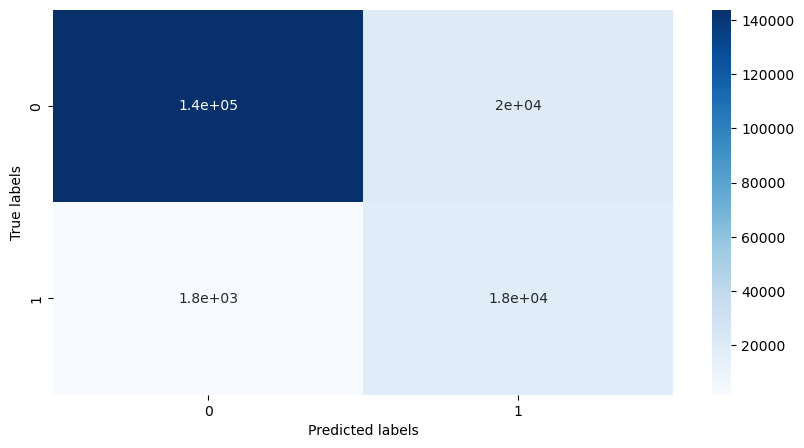

In [15]:
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels');


In [16]:
################################################################################
# METEOROLOGICAL BASELINE
# “If today's Tmax >= P95, then heat wave in the next 3 days”
################################################################################

# Daily maximum from test period
def meteorological_baseline(full_df, city_thresholds, test_index):

    
# Baseline: y_pred = 1 if today's Tmax >= city-specific P95

    
    predictions = pd.Series(0, index=test_index)
    
    for city, thresh in city_thresholds.items():
        # Daily maximum for this city
        city_df = engineered_frames[city]
        daily_max = city_df['temperature_2m'].resample('D').max()
        
        # Trial period only + summer months
        daily_max = daily_max[daily_max.index.isin(test_index)]
        
        # Forecast: above threshold today → alarm
        city_pred = (daily_max >= thresh).astype(int)
        predictions.update(city_pred)
    
    return predictions

y_baseline = meteorological_baseline(full_df, city_thresholds, X_test.index)

print("="*60)
print("METEOROLOGICAL BASELINE")
print("(Alarm if today's Tmax >= city-specific P95)")
print("="*60)
print(classification_report(y_test, y_baseline,
                             target_names=['no event', 'heat wave']))
print(f"ROC-AUC: {roc_auc_score(y_test, y_baseline):.4f}")
print(f"PR-AUC:  {average_precision_score(y_test, y_baseline):.4f}")
print(f"\nconfusionmatrix:\n{confusion_matrix(y_test, y_baseline)}")

print("\n" + "="*60)
print("MODEL vs. BASELINE")
print("="*60)
print(f"{'':25} {'Baseline':>10} {'Model':>10}")
print(f"{'PR-AUC':25} {average_precision_score(y_test, y_baseline):>10.4f} {average_precision_score(y_test, y_pred_proba):>10.4f}")
print(f"{'ROC-AUC':25} {roc_auc_score(y_test, y_baseline):>10.4f} {roc_auc_score(y_test, y_pred_proba):>10.4f}")
print(f"{'Recall heat wave':25} {(y_baseline[y_test==1]).mean():>10.4f} {(y_pred[y_test==1]).mean():>10.4f}")
print(f"{'Precision heat wave':25} {confusion_matrix(y_test, y_baseline)[1,1]/y_baseline.sum():>10.4f} {confusion_matrix(y_test, y_pred)[1,1]/y_pred.sum():>10.4f}")

METEOROLOGICAL BASELINE
(Alarm if today's Tmax >= city-specific P95)
              precision    recall  f1-score   support

    no event       0.89      0.99      0.94    163585
   heat wave       0.40      0.03      0.05     20015

    accuracy                           0.89    183600
   macro avg       0.65      0.51      0.50    183600
weighted avg       0.84      0.89      0.84    183600

ROC-AUC: 0.5119
PR-AUC:  0.1176

confusionmatrix:
[[162731    854]
 [ 19434    581]]

MODEL vs. BASELINE
                            Baseline      Model
PR-AUC                        0.1176     0.7590
ROC-AUC                       0.5119     0.9603
Recall heat wave              0.0290     0.9125
Precision heat wave           0.4049     0.4801


In [13]:
################################################################################
# HYPERPARAMETER TUNING WITH OPTUNA (PR-AUC enhancement)
################################################################################

import optuna
from sklearn.metrics import average_precision_score
optuna.logging.set_verbosity(optuna.logging.WARNING)  # less Output

def objective(trial):
    params = {
        'n_estimators':      trial.suggest_int('n_estimators', 300, 2000),
        'max_depth':         trial.suggest_int('max_depth', 3, 8),
        'learning_rate':     trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample':         trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree':  trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight':  trial.suggest_int('min_child_weight', 1, 10),
        'gamma':             trial.suggest_float('gamma', 0, 5),
        'scale_pos_weight':  scale_pos_weight,
        'objective':         'binary:logistic',
        'eval_metric':       'aucpr',
        'early_stopping_rounds': 30,
        'random_state':      42,
        'n_jobs':            -1,
    }
    
    model = xgb.XGBClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )
    
    y_proba = model.predict_proba(X_test)[:, 1]
    return average_precision_score(y_test, y_proba)


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

print(f"\n✅ Best PR-AUC: {study.best_value:.4f}")
print(f"\nBest Parameter:")
for k, v in study.best_params.items():
    print(f"  {k:<25} {v}")

################################################################################
# REPEAT TRAINING AND SAVE BEST MODEL
################################################################################

best_model = xgb.XGBClassifier(
    **study.best_params,
    scale_pos_weight = scale_pos_weight,
    objective        = 'binary:logistic',
    eval_metric      = 'aucpr',
    random_state     = 42,
    n_jobs           = -1,
)

best_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=50
)

y_pred_best       = best_model.predict(X_test)
y_pred_best_proba = best_model.predict_proba(X_test)[:, 1]

print("\n" + "="*60)
print("EVALUATION BEST MODEL")
print("="*60)
print(classification_report(y_test, y_pred_best,
                             target_names=['no event', 'heat wave']))
print(f"ROC-AUC:  {roc_auc_score(y_test, y_pred_best_proba):.4f}")
print(f"PR-AUC:   {average_precision_score(y_test, y_pred_best_proba):.4f}")

joblib.dump(best_model, 'model_tuned.pkl')
print("\n✅ Best Model saved.")

/home/simcard/.local/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Best trial: 26. Best value: 0.759049: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [04:43<00:00,  5.66s/it]



✅ Best PR-AUC: 0.7590

Best Parameter:
  n_estimators              1990
  max_depth                 4
  learning_rate             0.08238334754815374
  subsample                 0.6719836836980948
  colsample_bytree          0.849940297942439
  min_child_weight          10
  gamma                     3.39845966838663
[0]	validation_0-aucpr:0.44241
[50]	validation_0-aucpr:0.70746
[100]	validation_0-aucpr:0.73880
[150]	validation_0-aucpr:0.74983
[200]	validation_0-aucpr:0.75553
[250]	validation_0-aucpr:0.75808
[300]	validation_0-aucpr:0.75734
[350]	validation_0-aucpr:0.75638
[400]	validation_0-aucpr:0.75655
[450]	validation_0-aucpr:0.75641
[500]	validation_0-aucpr:0.75538
[550]	validation_0-aucpr:0.75611
[600]	validation_0-aucpr:0.75737
[650]	validation_0-aucpr:0.75567
[700]	validation_0-aucpr:0.75817
[750]	validation_0-aucpr:0.75719
[800]	validation_0-aucpr:0.75571
[850]	validation_0-aucpr:0.75445
[900]	validation_0-aucpr:0.75187
[950]	validation_0-aucpr:0.75348
[1000]	validation_0-auc

In [ ]:
!pip install shap --break-system-packages

False positive (FP): 19777
Right negative (TN): 143808

Top 15 differences FP vs TN:
                       Mean_FP   Mean_TN  Difference  SHAP_FP  SHAP_TN
heat_aridity_index     -43.423   -57.415      13.992    0.025    0.049
shortwave_radiation    232.883   240.328      -7.445    0.073    0.113
relative_humidity_2m    61.180    68.201      -7.022    0.016    0.017
t_850hPa               290.906   283.936       6.970    1.306    2.355
temperature_2m          24.245    19.087       5.158    0.173    0.173
lag_t850_72h           289.070   284.413       4.657    0.277    0.285
t_500hPa               263.143   259.304       3.839    0.095    0.379
lag_t500_48h           262.995   259.215       3.780    0.038    0.117
lag_t500_72h           262.762   259.219       3.543    0.024    0.060
wind_speed_10m          10.009    12.217      -2.208    0.080    0.137
delta_hum_24h           -1.490     0.362      -1.851    0.099    0.089
v_500hPa                 0.835    -0.584       1.419    0.068  

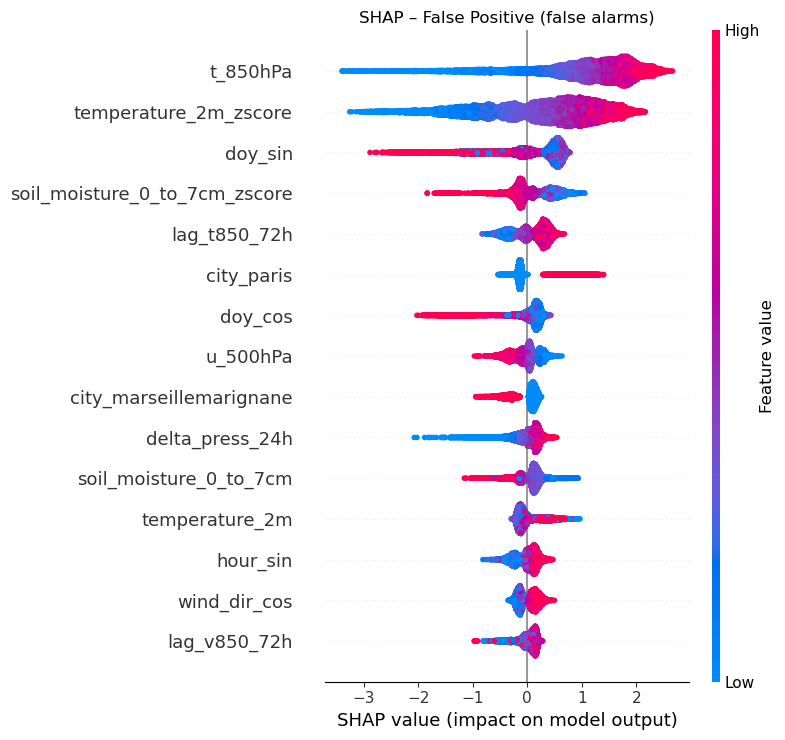

In [17]:
################################################################################
# SHAP: WHY FALSE POSITIVES?
################################################################################

import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# False positives: Model says 1, truth is 0
fp_mask = (y_test == 0) & (y_pred == 1)
tn_mask = (y_test == 0) & (y_pred == 0)

print(f"False positive (FP): {fp_mask.sum()}")
print(f"Right negative (TN): {tn_mask.sum()}")

# SHAP values for FP vs TN (True negatives)
shap_fp = shap_values[fp_mask.values]
shap_tn = shap_values[tn_mask.values]

X_fp = X_test[fp_mask]
X_tn = X_test[tn_mask]

################################################################################
# FEATURE AVERAGES: FP vs TN
################################################################################

feature_diff = pd.DataFrame({
    'Mean_FP':    X_fp.mean(),
    'Mean_TN':    X_tn.mean(),
    'Difference':  X_fp.mean() - X_tn.mean(),
    'SHAP_FP':    np.abs(shap_fp).mean(axis=0),
    'SHAP_TN':    np.abs(shap_tn).mean(axis=0),
}).sort_values('Difference', key=abs, ascending=False)

print("\nTop 15 differences FP vs TN:")
print("="*70)
print(feature_diff.head(15).round(3))

################################################################################
# SUMMARY PLOT ONLY FALSE POSITIVE
################################################################################

plt.figure()
shap.summary_plot(
    shap_fp,
    X_fp,
    max_display=15,
    show=False,
)
plt.title("SHAP – False Positive (false alarms)")
plt.tight_layout()
plt.savefig("shap_fp.png", dpi=150, bbox_inches='tight')
plt.show()

In [18]:
################################################################################
# SHAP ANALYSIS: RELEVANT VALUES AS A TABLE
################################################################################

import pandas as pd
import numpy as np

# 1. AVERAGE ABSOLUTE SHAP VALUES (Feature Importance)
shap_importance = pd.Series(
    np.abs(shap_values).mean(axis=0),
    index=feature_cols
).sort_values(ascending=False)

# 2. AVERAGE SHAP VALUES (direction of the effect)
shap_mean = pd.Series(
    shap_values.mean(axis=0),
    index=feature_cols
)

# 3. THRESHOLD VALUE: where does SHAP change from negative to positive?
def estimate_threshold(feature, shap_vals, X):
    feat_vals = X[feature].values
    s_vals    = shap_vals[:, X.columns.get_loc(feature)]
    idx = np.argsort(feat_vals)
    feat_sorted = feat_vals[idx]
    shap_sorted = s_vals[idx]
    sign_changes = np.where(np.diff(np.sign(shap_sorted)))[0]
    if len(sign_changes) > 0:
        return feat_sorted[sign_changes[0]]
    return np.nan

# 4. COMPILE TABLE
top_n = 20
top_features = shap_importance.head(top_n).index.tolist()

rows = []
for feat in top_features:
    rows.append({
        'Feature':              feat,
        'SHAP Importance':      round(float(shap_importance[feat]), 4),
        'SHAP direction (mean)': round(float(shap_mean[feat]), 4),
        'Effect':               '↑ heat event' if shap_mean[feat] > 0 else '↓ no event',
        'Threshold':        round(float(estimate_threshold(feat, shap_values, X_test)), 3),
        'Feature Mean':         round(float(X_test[feat].mean()), 3),
        'Feature Std':          round(float(X_test[feat].std()), 3),
    })

shap_table = pd.DataFrame(rows)

pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 120)
pd.set_option('display.float_format', '{:.4f}'.format)

print("="*120)
print("SHAP ANALYSIS: TOP 20 FEATURES")
print("="*120)
shap_table

SHAP ANALYSIS: TOP 20 FEATURES


,Feature,SHAP Importance,SHAP direction (mean),Effect,Threshold,Feature Mean,Feature Std
0,t_850hPa,2.1397,-1.3459,↓ no event,286.9360,285.5360,5.0990
1,temperature_2m_zscore,1.2895,-0.7769,↓ no event,0.5310,0.2200,1.0970
2,doy_sin,1.1332,-0.8677,↓ no event,-0.8360,-0.1850,0.6210
3,doy_cos,0.4560,-0.2905,↓ no event,-1.0000,-0.7110,0.2730
4,soil_moisture_0_to_7cm_zscore,0.3989,-0.0796,↓ no event,-1.1650,-0.4680,1.3170
5,soil_moisture_0_to_7cm,0.3650,-0.2164,↓ no event,0.0170,0.2050,0.0860
6,t_500hPa,0.3165,-0.2017,↓ no event,259.0100,260.1510,4.0370
7,lag_t850_72h,0.2838,-0.1199,↓ no event,269.2930,285.4410,5.1910
8,t_850hPa_zscore,0.2826,-0.1763,↓ no event,-0.3510,0.3210,1.0420
9,city_paris,0.2266,-0.0427,↓ no event,0.0000,0.2000,0.4000
